In [89]:
import yfinance as yf

import numpy as np
import pandas as pd
from math import sqrt
from pandas import DataFrame
from pandas import read_csv
from pandas import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

<ipython-input-89-7f48e2ddb901>:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [90]:
# Download historical data
main = yf.download("BTC-USD", start="2018-01-01", end="2022-01-31")

# Print the first few rows of the data
main.head()

print(main)

[*********************100%%**********************]  1 of 1 completed
                    Open          High           Low         Close  \
Date                                                                 
2018-01-01  14112.200195  14112.200195  13154.700195  13657.200195   
2018-01-02  13625.000000  15444.599609  13163.599609  14982.099609   
2018-01-03  14978.200195  15572.799805  14844.500000  15201.000000   
2018-01-04  15270.700195  15739.700195  14522.200195  15599.200195   
2018-01-05  15477.200195  17705.199219  15202.799805  17429.500000   
...                  ...           ...           ...           ...   
2022-01-26  36950.515625  38825.410156  36374.906250  36852.121094   
2022-01-27  36841.878906  37148.324219  35629.281250  37138.234375   
2022-01-28  37128.445312  37952.878906  36211.109375  37784.332031   
2022-01-29  37780.714844  38576.261719  37406.472656  38138.179688   
2022-01-30  38151.917969  38266.339844  37437.710938  37917.601562   

               Adj C

In [91]:
data = main.copy()

In [92]:
data.shape

(1491, 6)

In [93]:
# Extract Date Components
data['Year'] = data.index.year
data['Month'] = data.index.month
data['Day'] = data.index.day
data['DayOfWeek'] = data.index.dayofweek

In [94]:
# Create target variable for the next day's closing price
data['TargetNextClose'] = data['Adj Close'].shift(-1)

In [95]:
# Display the first few rows of the DataFrame
data.head()

,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day,DayOfWeek,TargetNextClose
Date,,,,,,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000,2018,1,1,0,14982.099609
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192,2018,1,2,1,15201.000000
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160,2018,1,3,2,15599.200195
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744,2018,1,4,3,17429.500000
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072,2018,1,5,4,17527.000000


In [96]:
# Display concise summary of DataFrame information
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1491 entries, 2018-01-01 to 2022-01-30
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             1491 non-null   float64
 1   High             1491 non-null   float64
 2   Low              1491 non-null   float64
 3   Close            1491 non-null   float64
 4   Adj Close        1491 non-null   float64
 5   Volume           1491 non-null   int64  
 6   Year             1491 non-null   int64  
 7   Month            1491 non-null   int64  
 8   Day              1491 non-null   int64  
 9   DayOfWeek        1491 non-null   int64  
 10  TargetNextClose  1490 non-null   float64
dtypes: float64(6), int64(5)
memory usage: 139.8 KB


In [97]:
# Generate descriptive statistics of the DataFrame
data.describe()

,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day,DayOfWeek,TargetNextClose
count,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000,1.491000e+03,1491.000000,1491.000000,1491.000000,1491.000000,1490.000000
mean,18821.611592,19315.184733,18264.990887,18834.535578,18834.535578,2.583597e+10,2019.550637,6.411804,15.725017,3.000000,18838.010299
std,17876.586972,18362.900800,17308.753528,17877.281815,17877.281815,2.104253e+10,1.161152,3.501980,8.800216,2.000671,17882.780263
min,3236.274658,3275.377930,3191.303467,3236.761719,3236.761719,2.923670e+09,2018.000000,1.000000,1.000000,0.000000,3236.761719
25%,7183.078369,7320.043701,6938.703369,7182.919678,7182.919678,8.463315e+09,2019.000000,3.000000,8.000000,1.000000,7179.667114
50%,9539.485352,9711.889648,9349.545898,9538.024414,9538.024414,2.248291e+10,2020.000000,6.000000,16.000000,3.000000,9537.458496
75%,32643.937500,33883.109375,31225.665039,32742.024414,32742.024414,3.620891e+10,2021.000000,9.000000,23.000000,5.000000,32762.023926
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11,2022.000000,12.000000,31.000000,6.000000,67566.828125


In [98]:
# Count the number of missing values in each column
data.isnull().sum()

Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
Year               0
Month              0
Day                0
DayOfWeek          0
TargetNextClose    1
dtype: int64

In [99]:
# Drop rows with missing values from the DataFrame
data = data.dropna()

In [100]:
# Display the shape of the DataFrame (number of rows and columns)
data.shape

(1490, 11)

In [101]:
# Create a datetime column from 'Year', 'Month', and 'Day'
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])

# Print the first and last date
first_date = data['Date'].min()
last_date = data['Date'].max()

print("First Date:", first_date)
print("Last Date:", last_date)

First Date: 2018-01-01 00:00:00
Last Date: 2022-01-29 00:00:00


<ipython-input-101-94bdbb45b7f8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])


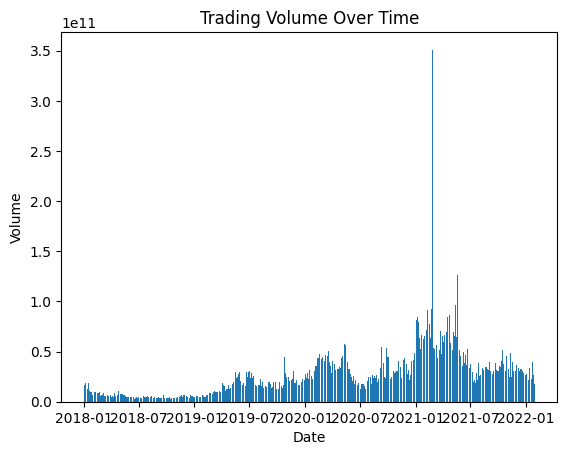

In [102]:
# Calculate basic statistics for volume
volume_stats = data['Volume'].describe()

# Visualize volume using a bar chart
plt.bar(data['Date'], data['Volume'])
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Trading Volume Over Time')
plt.show()

In [103]:
# Drop redundant columns from the DataFrame
data = data.drop(columns='Date')

In [104]:
# Check the data types of each column to ensure validity before using them for machine learning
data.dtypes

Open               float64
High               float64
Low                float64
Close              float64
Adj Close          float64
Volume               int64
Year                 int64
Month                int64
Day                  int64
DayOfWeek            int64
TargetNextClose    float64
dtype: object

In [105]:
# Normalize the 'data' DataFrame using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
data_set_scaled = scaler.fit_transform(data)

# Initialize empty lists for features (X) and target variable (y)
X = []
timesteps = 14

# Create input sequences for LSTM
for j in range(data.shape[1]):
    X.append([])
    for i in range(timesteps, data_set_scaled.shape[0]):
        # Append sequences of length 'timesteps' for each feature
        X[j].append(data_set_scaled[i - timesteps:i, j])

# Move axis from 0 to position 2 for compatibility with LSTM input
X = np.moveaxis(X, [0], [2])

# Convert lists to NumPy arrays
X, yi = np.array(X), np.array(data_set_scaled[timesteps:, -1])
y = np.reshape(yi, (len(yi), 1))

In [106]:
# Print the shapes of X and y
print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

Shape of X: (1476, 14, 11)
Shape of y: (1476, 1)


In [107]:
# Calculate the lengths for training (80%), validation (10%), and test (10%) sets
train_len = int(0.8 * len(data))
val_len = int(0.1 * len(data))
test_len = len(data) - train_len - val_len

# Split the features (X) and target variable (y) into training, validation, and test sets
X_train, y_train = X[:train_len], y[:train_len]
X_val, y_val = X[train_len:train_len + val_len], y[train_len:train_len + val_len]
X_test, y_test = X[train_len + val_len:], y[train_len + val_len:]

# Print the shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1192, 14, 11)
y_train shape: (1192, 1)
X_val shape: (149, 14, 11)
y_val shape: (149, 1)
X_test shape: (135, 14, 11)
y_test shape: (135, 1)


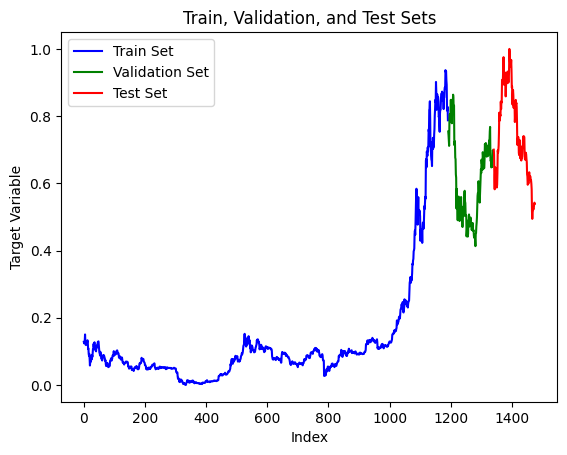

In [108]:
# Set Indices for Train, Validation, and Test Sets
train_indices = np.arange(len(X_train))
val_indices = np.arange(len(X_train), len(X_train) + len(X_val))
test_indices = np.arange(len(X_train) + len(X_val), len(X_train) + len(X_val) + len(X_test))

# Plot the Sets
plt.plot(train_indices, y_train, color='blue', label='Train Set')
plt.plot(val_indices, y_val, color='green', label='Validation Set')
plt.plot(test_indices, y_test, color='red', label='Test Set')
plt.xlabel('Index')
plt.ylabel('Target Variable')
plt.title('Train, Validation, and Test Sets')
plt.legend()
plt.show()

In [109]:
# Create a Sequential model
model = Sequential()

# Add LSTM layers
model.add(LSTM(100, return_sequences=True, input_shape=(timesteps, 11), name='first_layer'))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True, input_shape=(timesteps, 11), name='second_layer'))
model.add(Dropout(0.2))

# Add a Dense layer with linear activation
model.add(Dense(1, name='dense_layer'))

model.add(Activation('linear', name='output'))

# Compile the model using the Adam optimizer and mean squared error loss
adam_optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam_optimizer, loss='mse')

# Define callbacks for early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', mode = 'min', verbose=1, save_best_only=True)

# Train the model using training data
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=100, validation_split=0.1, callbacks=[early_stopping, checkpoint])

Epoch 1/100
28/34 [=======================>......] - ETA: 0s - loss: 0.0035
Epoch 1: val_loss improved from inf to 0.09660, saving model to model.h5
34/34 [==============================] - 6s 36ms/step - loss: 0.0031 - val_loss: 0.0966
Epoch 2/100
16/34 [=============>................] - ETA: 0s - loss: 0.0010

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/34 [=========================>....] - ETA: 0s - loss: 9.7779e-04
Epoch 2: val_loss improved from 0.09660 to 0.07225, saving model to model.h5
34/34 [==============================] - 0s 10ms/step - loss: 9.7135e-04 - val_loss: 0.0722
Epoch 3/100
29/34 [========================>.....] - ETA: 0s - loss: 7.9917e-04
Epoch 3: val_loss improved from 0.07225 to 0.06308, saving model to model.h5
34/34 [==============================] - 0s 10ms/step - loss: 7.8023e-04 - val_loss: 0.0631
Epoch 4/100
29/34 [========================>.....] - ETA: 0s - loss: 6.9099e-04
Epoch 4: val_loss improved from 0.06308 to 0.05129, saving model to model.h5
34/34 [==============================] - 0s 10ms/step - loss: 6.8940e-04 - val_loss: 0.0513
Epoch 5/100
28/34 [=======================>......] - ETA: 0s - loss: 6.1345e-04
Epoch 5: val_loss improved from 0.05129 to 0.04522, saving model to model.h5
34/34 [==============================] - 0s 10ms/step - loss: 6.0955e-04 - val_loss: 0.0452
Epoch 6/100
29/3

In [110]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_layer (LSTM)          (None, 14, 100)           44800     
                                                                 
 dropout_8 (Dropout)         (None, 14, 100)           0         
                                                                 
 second_layer (LSTM)         (None, 14, 100)           80400     
                                                                 
 dropout_9 (Dropout)         (None, 14, 100)           0         
                                                                 
 dense_layer (Dense)         (None, 14, 1)             101       
                                                                 
 output (Activation)         (None, 14, 1)             0         
                                                                 
Total params: 125301 (489.46 KB)
Trainable params: 125

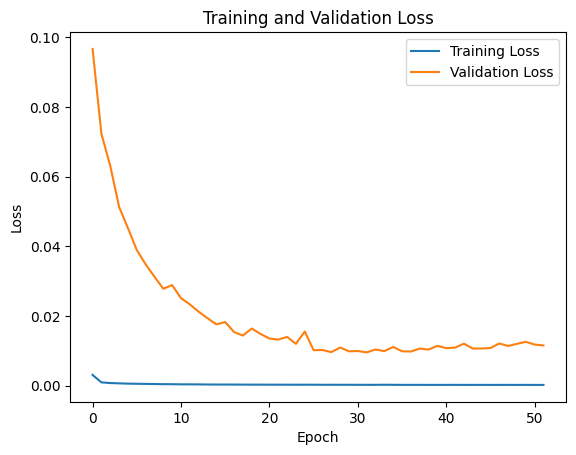

In [111]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [112]:
# Load the best model
model = load_model('model.h5')
model

In [113]:
# Make predictions on the training set
y_pred_train = model.predict(X_train)

# Extract the last prediction for each sequence
y_pred_train_last = y_pred_train[:, -1, :]

# Calculate R^2 for training set
r2_train = r2_score(y_train, y_pred_train_last)

# Calculate Mean Squared Error (MSE) for training set
mse_train = mean_squared_error(y_train, y_pred_train_last)

# Calculate Root Mean Squared Error (RMSE) for training set
rmse_train = np.sqrt(mse_train)

# Calculate Mean Absolute Error (MAE) for training set
mae_train = mean_absolute_error(y_train, y_pred_train_last)

# Calculate Mean Absolute Percentage Error (MAPE) for training set
mape_train = np.mean(np.abs((y_train - y_pred_train_last) / y_train)) * 100

# Print the results for training set
print("R^2 Score (Training Set):", r2_train)
print("Mean Squared Error (MSE) (Training Set):", mse_train)
print("Root Mean Squared Error (RMSE) (Training Set):", rmse_train)
print("Mean Absolute Error (MAE) (Training Set):", mae_train)
print("Mean Absolute Percentage Error (MAPE) (Training Set):", mape_train)

38/38 [==============================] - 1s 4ms/step
R^2 Score (Training Set): 0.9914106718830346
Mean Squared Error (MSE) (Training Set): 0.0003152748792155699
Root Mean Squared Error (RMSE) (Training Set): 0.01775598150527224
Mean Absolute Error (MAE) (Training Set): 0.010496468585509086
Mean Absolute Percentage Error (MAPE) (Training Set): inf


<ipython-input-113-7c1aba61cb76>:20: RuntimeWarning: divide by zero encountered in divide
  mape_train = np.mean(np.abs((y_train - y_pred_train_last) / y_train)) * 100


In [114]:
# Make predictions on the validation set
y_pred_val = model.predict(X_val)

# Extract the last prediction for each sequence
y_pred_val_last = y_pred_val[:, -1, :]

# Calculate R^2 for validation set
r2_val = r2_score(y_val, y_pred_val_last)

# Calculate Mean Squared Error (MSE) for validation set
mse_val = mean_squared_error(y_val, y_pred_val_last)

# Calculate Root Mean Squared Error (RMSE) for validation set
rmse_val = np.sqrt(mse_val)

# Calculate Mean Absolute Error (MAE) for validation set
mae_val = mean_absolute_error(y_val, y_pred_val_last)

# Calculate Mean Absolute Percentage Error (MAPE) for validation set
mape_val = np.mean(np.abs((y_val - y_pred_val_last) / y_val)) * 100

# Print the results for validation set
print("R^2 Score (Validation Set):", r2_val)
print("Mean Squared Error (MSE) (Validation Set):", mse_val)
print("Root Mean Squared Error (RMSE) (Validation Set):", rmse_val)
print("Mean Absolute Error (MAE) (Validation Set):", mae_val)
print("Mean Absolute Percentage Error (MAPE) (Validation Set):", mape_val)

5/5 [==============================] - 0s 4ms/step
R^2 Score (Validation Set): 0.8413931057274903
Mean Squared Error (MSE) (Validation Set): 0.0022952063232199223
Root Mean Squared Error (RMSE) (Validation Set): 0.04790831162981975
Mean Absolute Error (MAE) (Validation Set): 0.03906721403313699
Mean Absolute Percentage Error (MAPE) (Validation Set): 6.49890971532273


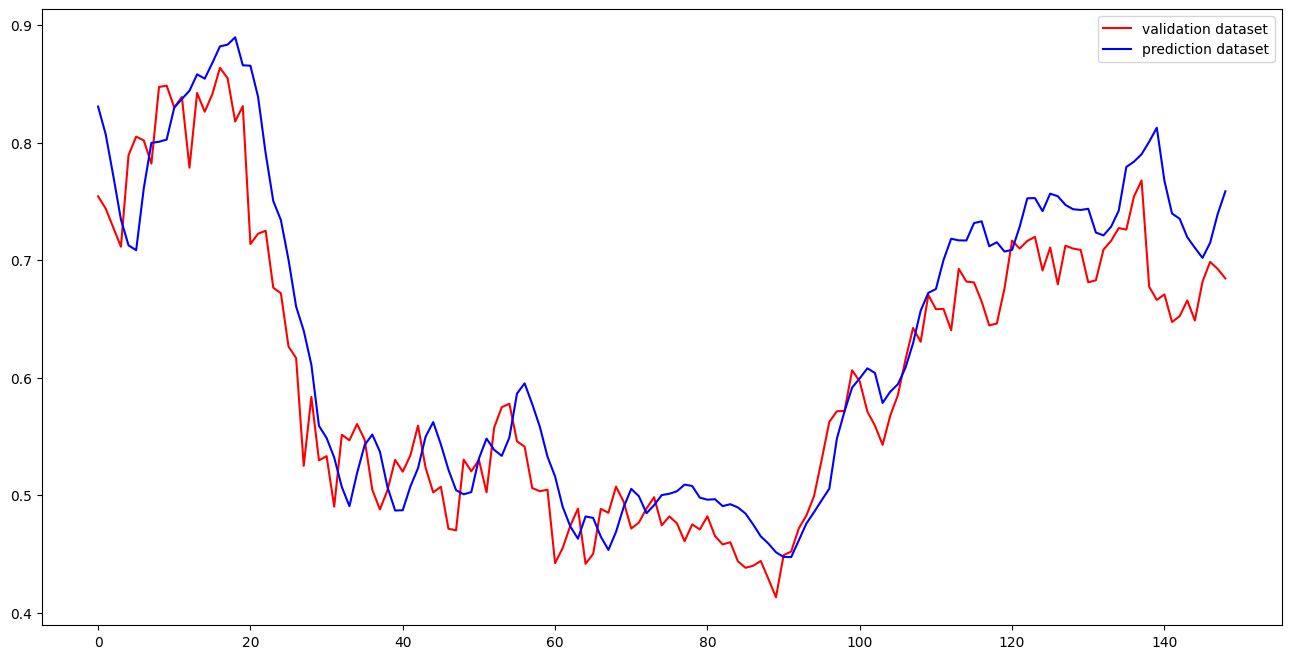

In [115]:
# Plot actual vs. predicted values for the validation set
plt.figure(figsize=(16,8))
plt.plot(y_val, color = 'red', label = 'validation dataset')
plt.plot(y_pred_val_last, color = 'blue', label = 'prediction dataset')
plt.legend()
plt.show()

In [116]:
# Make predictions on the validation set
y_test_val = model.predict(X_test)

# Extract the last prediction for each sequence
y_test_val_last = y_test_val[:, -1, :]

# Calculate R^2 for validation set
r2_val = r2_score(y_test, y_test_val_last)

# Calculate Mean Squared Error (MSE) for validation set
mse_val = mean_squared_error(y_test, y_test_val_last)

# Calculate Root Mean Squared Error (RMSE) for validation set
rmse_val = np.sqrt(mse_val)

# Calculate Mean Absolute Error (MAE) for validation set
mae_val = mean_absolute_error(y_test, y_test_val_last)

# Calculate Mean Absolute Percentage Error (MAPE) for validation set
mape_val = np.mean(np.abs((y_test - y_test_val_last) / y_test)) * 100

# Print the results for validation set
print("R^2 Score (Validation Set):", r2_val)
print("Mean Squared Error (MSE) (Validation Set):", mse_val)
print("Root Mean Squared Error (RMSE) (Validation Set):", rmse_val)
print("Mean Absolute Error (MAE) (Validation Set):", mae_val)
print("Mean Absolute Percentage Error (MAPE) (Validation Set):", mape_val)

5/5 [==============================] - 0s 6ms/step
R^2 Score (Validation Set): 0.47020291053119134
Mean Squared Error (MSE) (Validation Set): 0.009256796685037084
Root Mean Squared Error (RMSE) (Validation Set): 0.09621224810302004
Mean Absolute Error (MAE) (Validation Set): 0.08142570512769709
Mean Absolute Percentage Error (MAPE) (Validation Set): 10.572910833130306


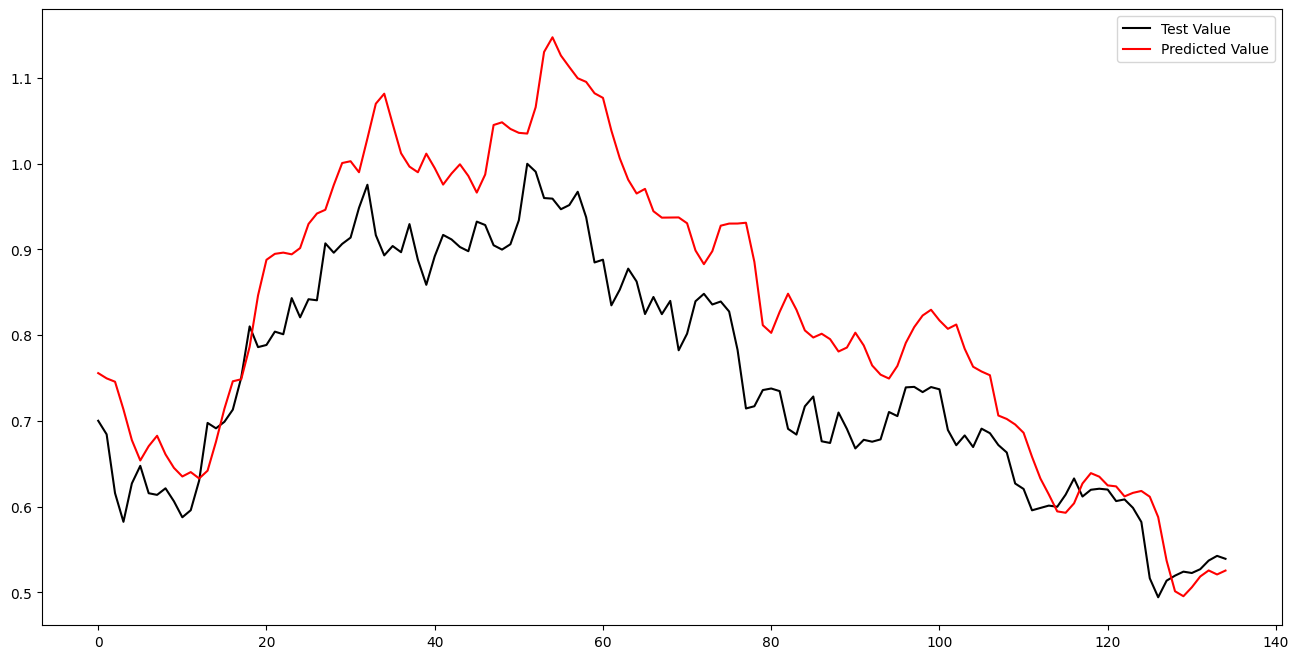

In [118]:
# Plot actual vs. predicted values for the validation set
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test Value')
plt.plot(y_test_val_last, color = 'red', label = 'Predicted Value')
plt.legend()
plt.show()